In [1]:
%matplotlib
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import math, gillespy2

from gillespy2.solvers.cpp.ssa_c_solver import SSACSolver
from gillespy2.solvers.numpy.basic_ode_solver import BasicODESolver

Using matplotlib backend: Qt5Agg


In [2]:
class DayModel(gillespy2.Model):
    def __init__(self, parameter_values=None, init_v=0):
        # initialize
        gillespy2.Model.__init__(self, name="Macrophage")
        
        # species
        S_ = gillespy2.Species(name='S_', initial_value=2e4) # low = 4e3; mid = 2e4; high = 1e7
        #A_ = gillespy2.Species(name='A_', initial_value=0)
        Hi_ = gillespy2.Species(name='Hi_', initial_value=0)
        HLN_ = gillespy2.Species(name='HLN_', initial_value=0)
        E_ = gillespy2.Species(name='E_', initial_value=2e9)
        Be_ = gillespy2.Species(name='Be_', initial_value=0)
        N_ = gillespy2.Species(name='N_', initial_value=0)
        TA_ = gillespy2.Species(name='TA_', initial_value=0)
        
        self.add_species([S_,Hi_,HLN_,E_,Be_,N_,TA_])
        
        # parameters
        ns = gillespy2.Parameter(name='ns', expression=3) # avg = 3.38
        nb = gillespy2.Parameter(name='nb', expression=5)

        k1 = gillespy2.Parameter(name='k1', expression=1e-5)
        k2 = gillespy2.Parameter(name='k2', expression=1e-10)
        k3 = gillespy2.Parameter(name='k3', expression=0.05)
        k4 = gillespy2.Parameter(name='k4', expression=2)
        k5 = gillespy2.Parameter(name='k5', expression=0.8)
        k6 = gillespy2.Parameter(name='k6', expression=5e-10)
        k8 = gillespy2.Parameter(name='k8', expression=6e-10)
        k9 = gillespy2.Parameter(name='k9', expression=5e-10)
        k10 = gillespy2.Parameter(name='k10', expression=1e-5)

        Sa = gillespy2.Parameter(name='Sa', expression=3e8)
        Se = gillespy2.Parameter(name='Se', expression=1e8)

        MuA = gillespy2.Parameter(name='MuA', expression=0.05)
        MuE = gillespy2.Parameter(name='MuE', expression=0.05)
        MuN = gillespy2.Parameter(name='MuN', expression=0.06)
        MuTA = gillespy2.Parameter(name='MuTA', expression=2)

        N0 = gillespy2.Parameter(name='N0', expression=5500)

        BeMAX = gillespy2.Parameter(name='BeMAX', expression=5e11)

        CT1 = gillespy2.Parameter(name='CT1', expression=1)
        CT2 = gillespy2.Parameter(name='CT2', expression=1)
        CT3 = gillespy2.Parameter(name='CT3', expression=1)
        CTB = gillespy2.Parameter(name='CTB', expression=1000)
        
        
        #self.add_parameter([ns,k2,k3,Sa,MuA])
        self.add_parameter([ns,nb,k1,k2,k3,k4,k5,k6,k8,k9,k10,Sa,Se,MuA,MuE,MuN,MuTA,N0,BeMAX,CT1,CT2,CT3,CTB])
        
        # reactions
        R1 = gillespy2.Reaction(
            name='R1',
            reactants={S_:float(ns.expression)},
            products={Hi_:1},
            propensity_function="(k2*S_*(Sa/(k2*S_ + MuA)))/ns"
        )
        
        R2 = gillespy2.Reaction(
            name='R2',
            reactants={Hi_:1},
            products={HLN_:1},
            rate=k3
        )
        
        R3 = gillespy2.Reaction(
            name='R3',
            reactants={},
            products={E_:1},
            rate=Se
        )
        
        R4 = gillespy2.Reaction(
            name='R4',
            reactants={E_:1},
            products={},
            rate=MuE
        )
        
        R5 = gillespy2.Reaction(
            name='R5',
            reactants={E_:1,Be_:1},
            products={},
            rate=k1
        )
        
        R6 = gillespy2.Reaction(
            name='R6',
            reactants={HLN_:1},
            products={Be_:float(nb.expression)},
            rate=k3
        )
        
        R7 = gillespy2.Reaction(
            name='R7',
            reactants={Be_:1},
            products={Be_:1},
            propensity_function="k5*Be_*(1 - (Be_/BeMAX))"
        )
        
        R8 = gillespy2.Reaction(
            name='R8',
            reactants={E_:1,Be_:1},
            products={},
            rate=k6
        )
        
        R9 = gillespy2.Reaction(
            name='R9',
            reactants={N_:1,Be_:1},
            products={},
            propensity_function="(k8*N_*Be_)/(1+(TA_/CT1))"
        )
        
        R10 = gillespy2.Reaction(
            name='R10',
            reactants={Be_:1,E_:1},
            products={N_:1},
            propensity_function="(k9*Be_*E_*N0)/(1+(TA_/CT2))"
        )
        
        R11 = gillespy2.Reaction(
            name='R11',
            reactants={N_:1},
            products={N_:1},
            propensity_function="(k10*N_*N0)/(1+(TA_/CT3))"
        )
        
        R12 = gillespy2.Reaction(
            name='R12',
            reactants={N_:1},
            products={},
            rate=MuN
        )
        
        R13 = gillespy2.Reaction(
            name='R13',
            reactants={Be_:1},
            products={TA_:1},
            propensity_function="k4*(Be_/(CTB+Be_))"
        )
        
        R14 = gillespy2.Reaction(
            name='R14',
            reactants={TA_:1},
            products={},
            rate=MuTA
        )
                
        self.add_reaction([R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11,R12,R13,R14])
        t = numpy.linspace(0,20,401)
        self.timespan(t)

In [3]:
model = DayModel()

In [4]:
%time results = model.run(solver=BasicODESolver)

Wall time: 59.9 ms


Initial spores: 20000.0
Spores remaining: 366.32725157622866
Intralung host cells: 9321.738103215559


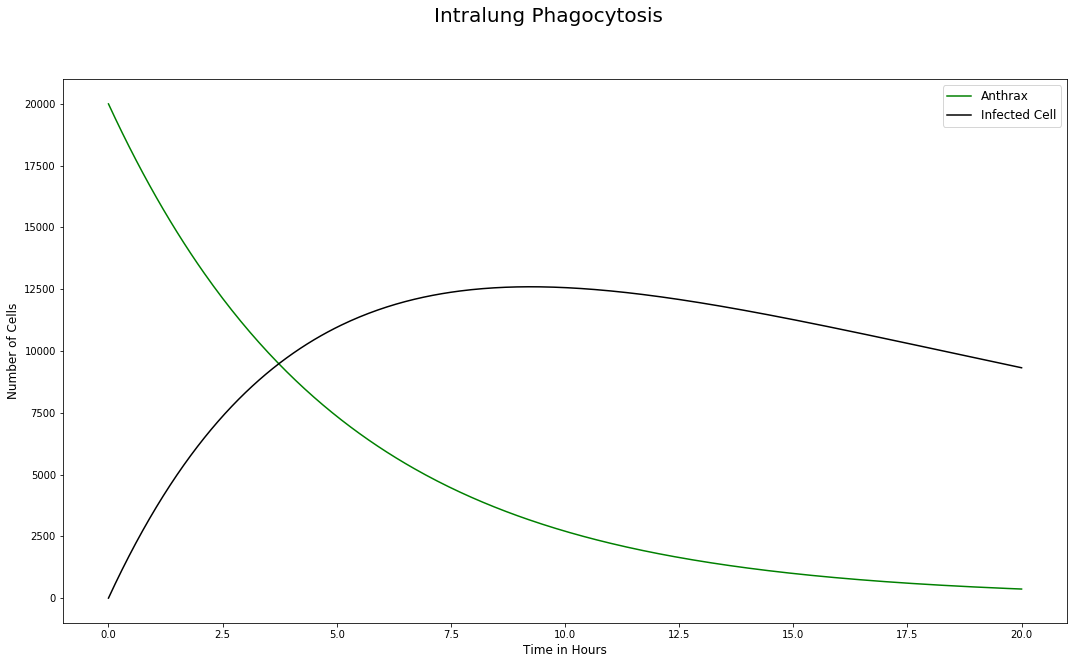

In [5]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Intralung Phagocytosis", fontsize=20)
plt.plot(results[0]['time'], results[0]['S_'], 'g-', label='Anthrax')
#plt.plot(results['time'], results['M_'], 'b-', label='Macrophage')
plt.plot(results[0]['time'], results[0]['Hi_'], 'k-', label='Infected Cell')
plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)
#print(results['S_'][-1]/(results['S_'][0]/int(model.listOfParameters['ns'].expression)))
#print(results['H_'][-1])
print("Initial spores: {}".format(results[0]['S_'][0]))
print("Spores remaining: {}".format(results[0]['S_'][-1]))
print("Intralung host cells: {}".format(results[0]['Hi_'][-1]))




Host Cells in Lung: 9321.738103215559
Spores at x hours: 1641.760415596695
Spores at x hours: 1625.4246816355824
Host Cells in TMLN: 6702.864444087292


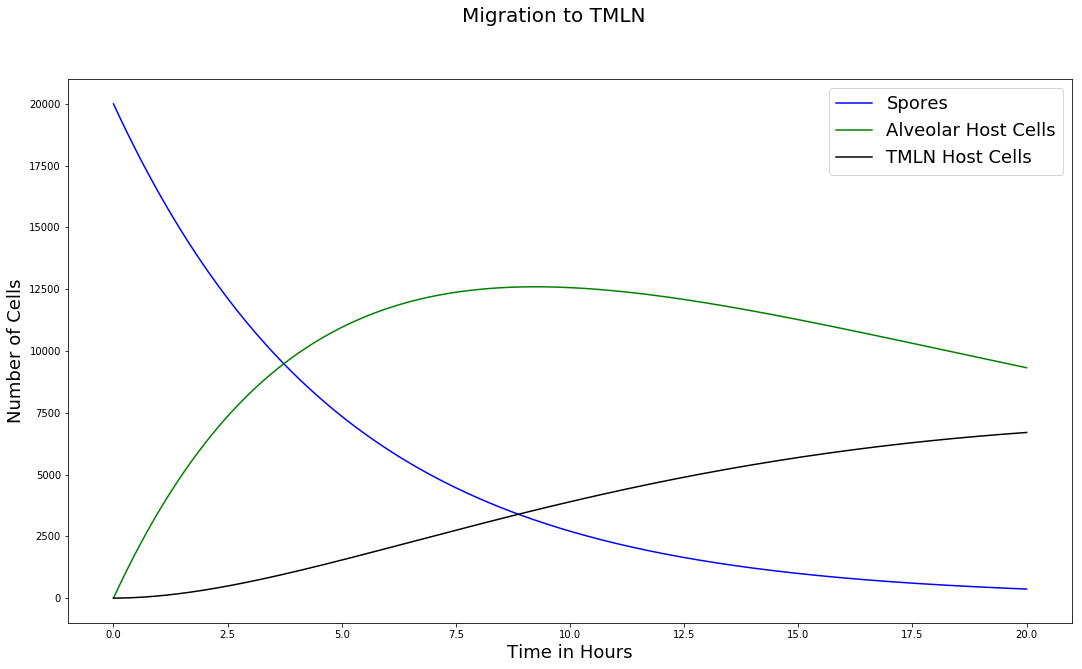

In [13]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Migration to TMLN", fontsize=20)
plt.plot(results[0]['time'], results[0]['S_'], 'b', label='Spores')
plt.plot(results[0]['time'], results[0]['Hi_'], 'g-', label='Alveolar Host Cells')
plt.plot(results[0]['time'], results[0]['HLN_'], 'k-', label='TMLN Host Cells')
plt.xlabel("Time in Hours", fontsize=18)
plt.ylabel("Number of Cells", fontsize=18)
plt.legend(loc='best', fontsize=18)
print("Host Cells in Lung: {}".format(results[0]['Hi_'][-1]))
print("Spores at x hours: {}".format(results[0]['S_'][250]))
print("Spores at x hours: {}".format(results[0]['S_'][251]))
print("Host Cells in TMLN: {}".format(results[0]['HLN_'][-1]))


Lymphocyte Cells: 1999997329.2639363


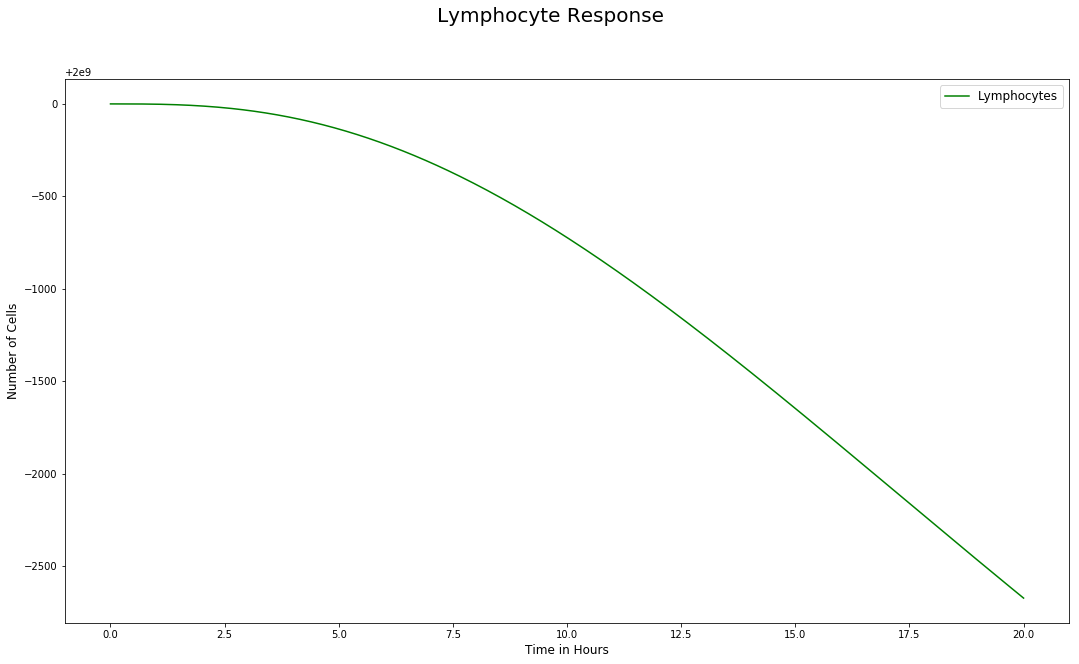

In [7]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Lymphocyte Response", fontsize=20)
plt.plot(results[0]['time'], results[0]['E_'], 'g-', label='Lymphocytes')
plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)
#print(results['S_'][-1]/(results['S_'][0]/int(model.listOfParameters['ns'].expression)))
#print(results['H_'][-1])
print("Lymphocyte Cells: {}".format(results[0]['E_'][-1]))

Extracellular Cells: 0.013142399373517107


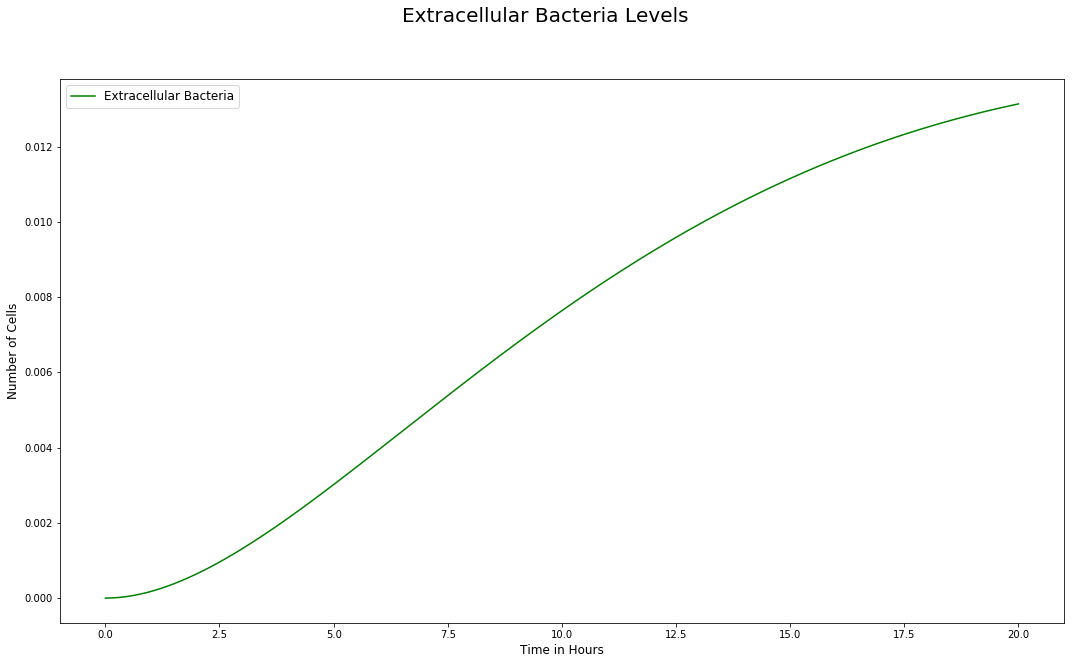

In [8]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Extracellular Bacteria Levels", fontsize=20)
plt.plot(results[0]['time'], results[0]['Be_'], 'g-', label='Extracellular Bacteria')
plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)
#print(results['S_'][-1]/(results['S_'][0]/int(model.listOfParameters['ns'].expression)))
#print(results['H_'][-1])
print("Extracellular Cells: {}".format(results[0]['Be_'][-1]))

Lymphocyte Cells: 545.2261323745407


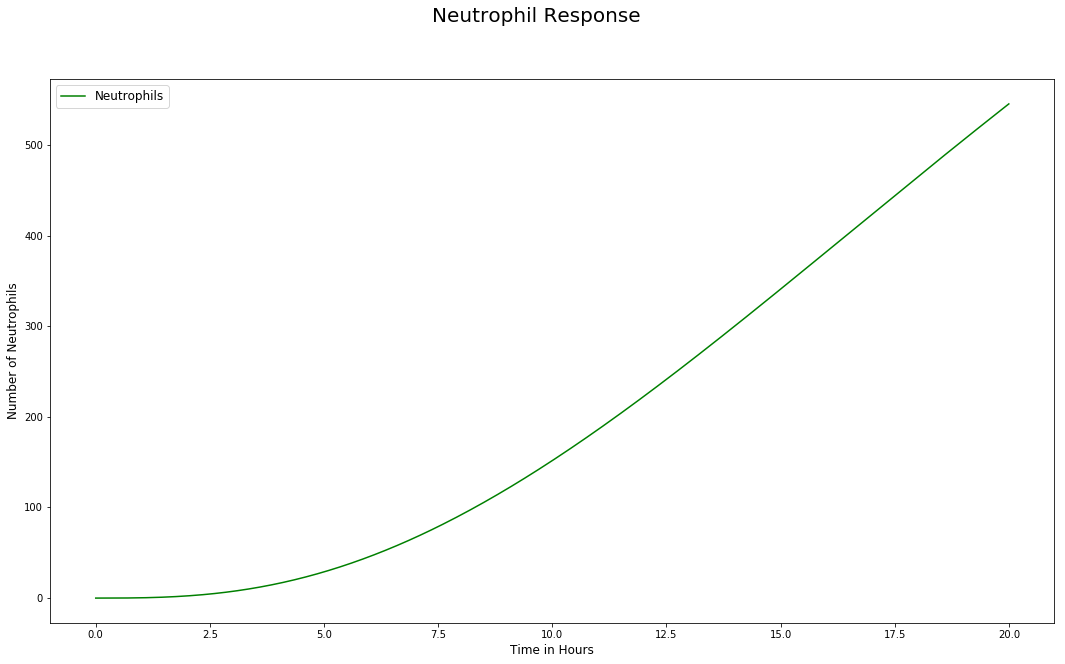

In [9]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Neutrophil Response", fontsize=20)
plt.plot(results[0]['time'], results[0]['N_'], 'g-', label='Neutrophils')
plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Neutrophils", fontsize=12)
plt.legend(loc='best', fontsize=12)
#print(results['S_'][-1]/(results['S_'][0]/int(model.listOfParameters['ns'].expression)))
#print(results['H_'][-1])
print("Lymphocyte Cells: {}".format(results[0]['N_'][-1]))

Toxins: 1.3000647170549629e-05


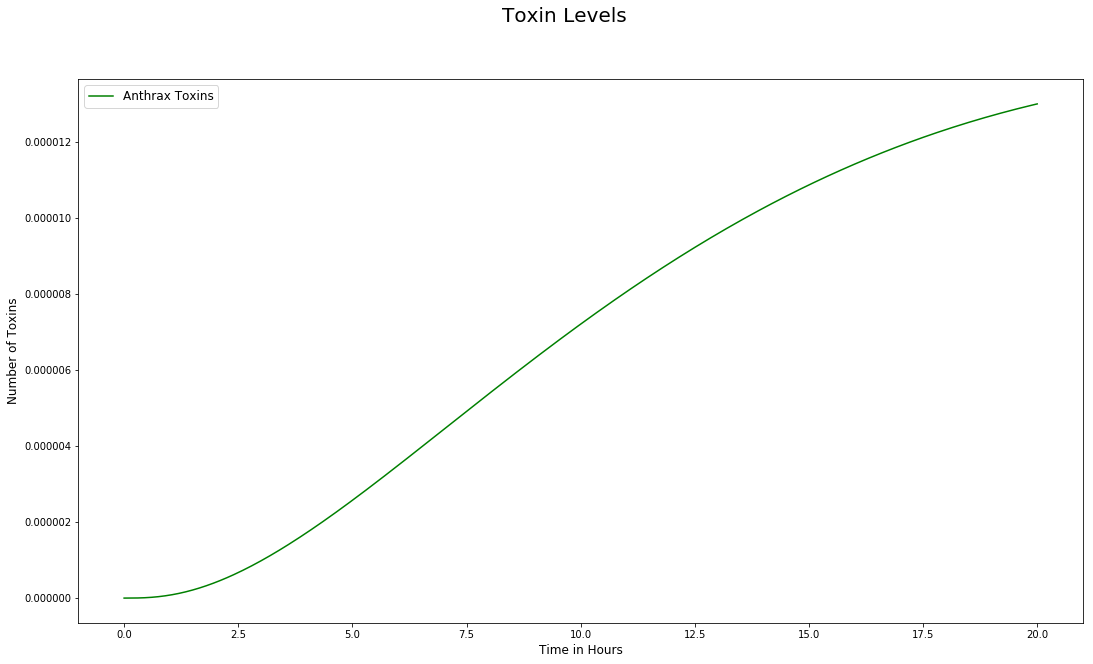

2019-04-20 00:14:47,067 - tornado.application - ERROR - Exception in callback functools.partial(<function wrap.<locals>.null_wrapper at 0x000002307088F9D8>)
Traceback (most recent call last):
  File "C:\Users\devgruseal\Anaconda3\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\devgruseal\Anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\devgruseal\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 306, in advance_eventloop
    eventloop(self)
TypeError: 'NoneType' object is not callable


In [10]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Toxin Levels", fontsize=20)
plt.plot(results[0]['time'], results[0]['TA_'], 'g-', label='Anthrax Toxins')
plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Toxins", fontsize=12)
plt.legend(loc='best', fontsize=12)
#print(results['S_'][-1]/(results['S_'][0]/int(model.listOfParameters['ns'].expression)))
#print(results['H_'][-1])
print("Toxins: {}".format(results[0]['TA_'][-1]))